In [1]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [2]:
seed = np.random.seed(147)

In [3]:
def load_X_npy() -> list:
    """Form a complex number."""
    
    train_X_array = np.load('project_data/processed_train_X.npy')
    train_y_array = np.load('project_data/processed_train_y.npy')
    #test_X_array = np.load('project_data/processed_test_X.npy')
    
    return [train_X_array, train_y_array]#, test_X_array]

In [4]:
train_X_array, train_y_array = load_X_npy()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(train_X_array, train_y_array, test_size=0.25, random_state=seed)

# Validation

In [6]:
def pipe_skf_grid_model(X_train, X_test, y_train, y_test: np.array, save: bool = False) -> None:
    """Form a complex number.

    Keyword arguments:
    real -- the real part (default 0.0)
    imag -- the imaginary part (default 0.0)
    """
    
    pipe = Pipeline([("classifier", SVC())])
    
    search_space = [
        {"classifier": [LinearSVC(max_iter=100000, random_state=seed)],
        "classifier__penalty": ["l1", "l2"],
        "classifier__C": np.logspace(1, 10, 25),
        "classifier__class_weight": [None, "balanced"]
        },

        {"classifier": [KNeighborsClassifier()],
        "classifier__n_neighbors": np.arange(2, 60, 2),
        "classifier__weights": ["uniform", "distance"],
        "classifier__leaf_size": np.arange(2, 60, 2)
        },
        
        {"classifier": [ExtraTreesClassifier(random_state=seed)],
        "classifier__n_estimators": np.arange(90, 135, 1),
        "classifier__criterion": ["gini", "entropy"],
        "classifier__class_weight": [None, "balanced", "balanced_subsample"],
        "classifier__min_samples_split": np.arange(1, 5, 1)
        }
    ]
    
    rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed)
    gridsearch = GridSearchCV(pipe, search_space, cv=rskf, scoring="f1_micro", verbose=1, n_jobs=-1)
    best_model = gridsearch.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    
    print(f"\nBest model params: \n{best_model.best_params_}")
    # UserWarning: One or more of the test scores are non-finite
    print(f"\nModel scorer: \n{best_model.scorer_}")
    print(f"\nModel score: \n{best_model.best_score_}")
    
    if save:
        filename = "binary_clf_model.sav"
        joblib.dump(best_model, filename)
        
    return y_pred

In [7]:
%time y_pred = pipe_skf_grid_model(X_train, X_test, y_train, y_test, save=True)

Fitting 30 folds for each of 2862 candidates, totalling 85860 fits


C:\Users\DJaskulski\miniconda3\envs\cdv_data_prep\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.86889305        nan ... 0.90907982 0.90863687 0.90864413]
  warnings.warn(



Best model params: 
{'classifier': ExtraTreesClassifier(class_weight='balanced_subsample', n_estimators=117), 'classifier__class_weight': 'balanced_subsample', 'classifier__criterion': 'gini', 'classifier__min_samples_split': 2, 'classifier__n_estimators': 117}

Model scorer: 
make_scorer(f1_score, pos_label=None, average=micro)

Model score: 
0.915673289183223
Wall time: 22min 34s


In [8]:
def clf_report_with_cm(y_true, y_pred: np.array) -> None:
    """Form a complex number.

    Keyword arguments:
    real -- the real part (default 0.0)
    imag -- the imaginary part (default 0.0)
    """
    
    # classification report
    target_names = ['class -1', 'class 1']
    print(classification_report(y_true, y_pred, target_names=target_names))

    # confusion matrix with plot
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    
    disp.plot() 

In [9]:
plt.rcParams["figure.figsize"] = (6,6)

              precision    recall  f1-score   support

    class -1       0.90      0.89      0.89       166
     class 1       0.94      0.95      0.95       341

    accuracy                           0.93       507
   macro avg       0.92      0.92      0.92       507
weighted avg       0.93      0.93      0.93       507



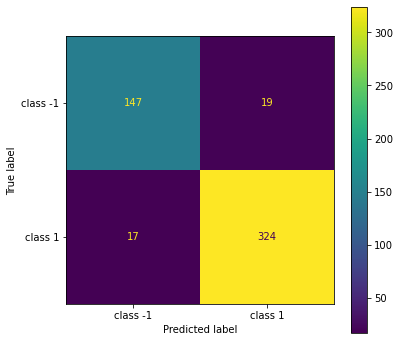

In [10]:
clf_report_with_cm(y_test, y_pred)

# Execution

In [11]:
# # load the model from disk
# filename = "binary_clf_model.sav"
# loaded_model = joblib.load(filename)

# # result = loaded_model.score(X_test, Y_test)
# # print(result)

# # predicting
# predicted = loaded_model.predict(test_X_array)

In [12]:
# pd.DataFrame(predicted) 

In [13]:
# predicted.to_csv("project_data/test_labels.csv")